https://github.com/nerfstudio-project/gsplat/issues/234

In [1]:
import os
import torch
import numpy as np
from plyfile import PlyData
from gsplat import rasterization
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

In [4]:
# path of ply file
file_path = os.path.abspath(os.path.join("..", "data", "point_cloud.ply"))

In [ ]:
# Read ply file
gs_ply_data = PlyData.read(file_path)
# each vertex represents as gaussian
vertices = gs_ply_data['vertex']
vertices


PlyElement('vertex', (PlyProperty('x', 'float'), PlyProperty('y', 'float'), PlyProperty('z', 'float'), PlyProperty('nx', 'float'), PlyProperty('ny', 'float'), PlyProperty('nz', 'float'), PlyProperty('f_dc_0', 'float'), PlyProperty('f_dc_1', 'float'), PlyProperty('f_dc_2', 'float'), PlyProperty('f_rest_0', 'float'), PlyProperty('f_rest_1', 'float'), PlyProperty('f_rest_2', 'float'), PlyProperty('f_rest_3', 'float'), PlyProperty('f_rest_4', 'float'), PlyProperty('f_rest_5', 'float'), PlyProperty('f_rest_6', 'float'), PlyProperty('f_rest_7', 'float'), PlyProperty('f_rest_8', 'float'), PlyProperty('f_rest_9', 'float'), PlyProperty('f_rest_10', 'float'), PlyProperty('f_rest_11', 'float'), PlyProperty('f_rest_12', 'float'), PlyProperty('f_rest_13', 'float'), PlyProperty('f_rest_14', 'float'), PlyProperty('f_rest_15', 'float'), PlyProperty('f_rest_16', 'float'), PlyProperty('f_rest_17', 'float'), PlyProperty('f_rest_18', 'float'), PlyProperty('f_rest_19', 'float'), PlyProperty('f_rest_20', 'f

In [18]:
 # Extract positions: [N, 3]
means = np.vstack([vertices['x'], vertices['y'], vertices['z']]).T # each element : (num_points,)
means.shape

(899421, 3)

In [19]:
# Extract scales: [N, 3]
scales = np.vstack([vertices['scale_0'], vertices['scale_1'], vertices['scale_2']]).T

# Extract quaternions: [N, 4]
quats = np.vstack([vertices['rot_0'], vertices['rot_1'], vertices['rot_2'], vertices['rot_3']]).T

# Extract opacities: [N]
opacities = np.array(vertices['opacity'])

In [47]:
# --- Reconstruct SH coefficients ---
# Extract f_dc_0, f_dc_1, f_dc_2 → 3 values per vertex.
sh0_list = []
for i in range(3):
    prop_name = f'f_dc_{i}'
    if prop_name not in vertices.data.dtype.names:
        raise KeyError(f"Property {prop_name} not found in PLY file.")
    sh0_list.append(np.array(vertices[prop_name]))
sh0 = np.array(sh0_list).T
# convert sh0 range to [0, 1]
sh0 = 0.2820947917738781 * sh0 + 0.5
sh0

array([[0.99607843, 0.99607843, 0.99607843],
       [0.99607843, 0.99607843, 0.99607843],
       [0.99607843, 0.99607843, 0.99607843],
       ...,
       [0.467053  , 0.481423  , 0.5018796 ],
       [0.6369153 , 0.633901  , 0.5679625 ],
       [0.1644992 , 0.19291401, 0.20597103]], dtype=float32)

In [42]:
# Extract f_rest_0 ... f_rest_44 → 45 values per vertex.
shN_list = []
for i in range(45):
    prop_name = f'f_rest_{i}'
    if prop_name not in vertices.data.dtype.names:
        raise KeyError(f"Property {prop_name} not found in PLY file.")
    shN_list.append(np.array(vertices[prop_name]))
shN = np.stack(shN_list, axis=1)
shN.shape

(899421, 45)

In [45]:
# Concatenate the two groups: total channels = 3 + 45 = 48.
sh= np.concatenate([sh0, shN], axis=1)

# Reshape to [N, K, 3] where K = 48 / 3 = 16.
N = sh.shape[0]
total_channels = sh.shape[1]
if total_channels % 3 != 0:
    raise ValueError("Total number of SH channels is not a multiple of 3.")
K = total_channels // 3  # Should be 16.
colors = sh.reshape(N, K, 3)  # Shape: [N, 16, 3]
colors.shape

(899421, 16, 3)

In [50]:
# Convert all arrays to torch tensors.
splats = {
    "means":     torch.from_numpy(means).float(),      # [N, 3]
    "scales":    torch.from_numpy(scales).float(),     # [N, 3]
    "quats":     torch.from_numpy(quats).float(),      # [N, 4]
    "opacities": torch.from_numpy(opacities).float(),    # [N]
    "colors":    torch.from_numpy(colors).float(),      # [N, 16, 3]
}

# print all
for key, value in splats.items():
    print(f"{key}: {value.shape}")

means: torch.Size([899421, 3])
scales: torch.Size([899421, 3])
quats: torch.Size([899421, 4])
opacities: torch.Size([899421])
colors: torch.Size([899421, 16, 3])


In [ ]:
# render
device = torch.device("cuda:0")

means     = splats["means"].to(device)
quats     = splats["quats"].to(device)
scales    = splats["scales"].to(device)
opacities = splats["opacities"].to(device)
colors    = splats["colors"].to(device)  # (N,16,3) など

# viewmats  = torch.eye(4, device=device)[None, :, :]
# Ks        = torch.tensor([
#    [300., 0., 150.],
#    [0., 300., 100.],
#    [0.,   0.,   1.]], device=device)[None, :, :]

# width, height = 300, 200


import sys
sys.path.append('..')  # Adjust the path as necessary to locate the 'mine' module
from mine.read_transformers import readNerfSyntheticCameras, fov2focal
from pathlib import Path

nerf_dataset_path = os.path.abspath(os.path.join("..", "data", "transformers"))

train_cams, test_cams = readNerfSyntheticCameras(nerf_dataset_path, white_background=True, extension=".png", eval_mode=True)

print(len(train_cams), "training cameras")
print(len(test_cams), "test cameras")

# 例: 取り出し
for cam in train_cams[:1]:
    print("uid=", cam.uid)
    print("R=", cam.R)
    print("T=", cam.T)
    print("FovX(deg)=", np.degrees(cam.FovX))
    print("FovY(deg)=", np.degrees(cam.FovY))
    print("image_name=", cam.image_name)
    print("image size=", (cam.width, cam.height))
    print("---")


Reading Training Transforms...
64 training cameras
0 test cameras
uid= 0
R= [[ 1. -0. -0.]
 [ 0. -1. -0.]
 [ 0. -0. -1.]]
T= [ 16.804981 -16.804981  20.      ]
FovX(deg)= 39.597755335771296
FovY(deg)= 39.597755335771296
image_name= 0000
image size= (1600, 1600)
---


In [55]:
# 0番目カメラを取り出す
cam = train_cams[0]
width, height = cam.width/4, cam.height/4

# f_x, f_y を計算
f_x = fov2focal(cam.FovX, width)   # 横幅に対する焦点距離
f_y = fov2focal(cam.FovY, height)  # 縦幅に対する焦点距離

# 光学中心 cx, cy (画像中心と仮定)
cx = width  / 2.0
cy = height / 2.0

# Intrinsics 行列
K = np.array([
    [f_x,   0,   cx],
    [  0, f_y,   cy],
    [  0,   0,   1 ]
], dtype=np.float32)

print("K =\n", K)

K =
 [[555.55554   0.      200.     ]
 [  0.      555.55554 200.     ]
 [  0.        0.        1.     ]]


In [56]:
# 4x4 のワールド→カメラ変換 (Extrinsic) を作る
W2C = np.eye(4, dtype=np.float32)
W2C[:3, :3] = cam.R  # cam.R はすでに転置済みの場合あり; それは readNerfSyntheticInfo の仕様
W2C[:3,  3] = cam.T

print("W2C =\n", W2C)

# 内部パラメータ
K_3x3 = K[:3, :3]  # 上で計算したintrinsics, 3x3部だけ使う

# ライブラリに合った形に reshape/unsqueeze するなど
viewmats = torch.from_numpy(W2C)[None, :, :].to(device)  # 1カメラ分の4x4行列をCUDAへ
Ks       = torch.from_numpy(K_3x3)[None, :, :].to(device) # 1カメラ分の3x3行列をCUDAへ

W2C =
 [[  1.        -0.        -0.        16.804981]
 [  0.        -1.        -0.       -16.804981]
 [  0.        -0.        -1.        20.      ]
 [  0.         0.         0.         1.      ]]


In [59]:
rgb_image, alpha, metadata = rasterization(
    means,
    quats,
    scales,
    opacities,
    colors,
    viewmats,
    Ks,
    width,
    height,
    sh_degree=3,
)

ImportError: /home/uno/.cache/torch_extensions/py310_cu118/gsplat_cuda/gsplat_cuda.so: cannot open shared object file: No such file or directory

(-0.5, 299.5, 199.5, -0.5)

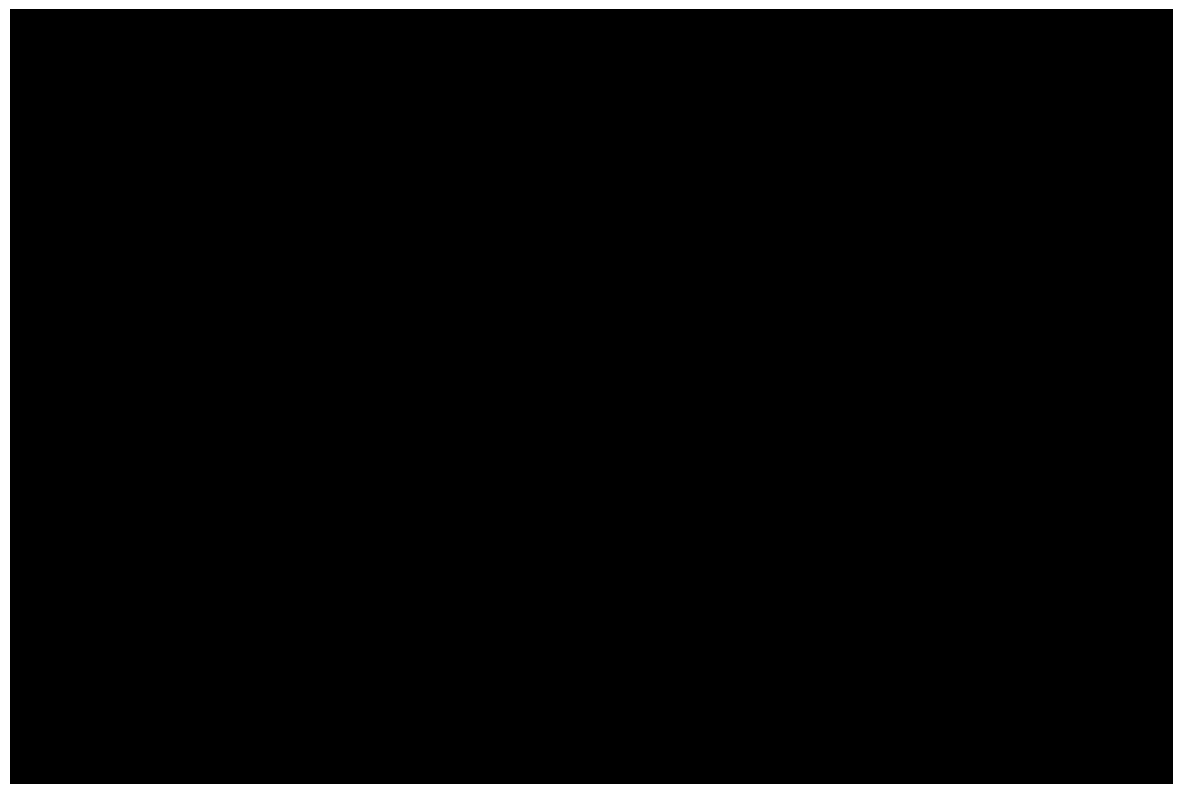

In [ ]:
# Display the rendered image.
plt.imshow(rgb_image.squeeze().cpu().detach().numpy())
plt.axis("off")
